## Train a CNN to Recognise Words

The stamp process in the '_Data' notebook has produced some nice-looking spectrograms with a uniform (64,32) shape. 

Let's just recognise the words the stamps represent by learning to differentiate between the 'stamp' images : a task for which the MNIST CNN is almost perfect for...

In [1]:
"""Convolutional Neural Network Estimator, built with tf.layers (originally for MNIST)."""

#  FROM : https://www.tensorflow.org/tutorials/layers#building_the_cnn_mnist_classifier
#  CODE : https://www.tensorflow.org/code/tensorflow/examples/tutorials/layers/cnn_mnist.py

import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

import tensorflow as tf

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
from tensorflow.contrib.learn.python.learn.estimators import run_config

tf.logging.set_verbosity(tf.logging.INFO)  # Quite a lot...
#tf.logging.set_verbosity(tf.logging.WARN)   # This prevents Logging ...

do_training = True

In [2]:
import sys
print(sys.version)
print('Tensorflow:',tf.__version__)

3.6.2 |Anaconda, Inc.| (default, Sep 30 2017, 18:42:57) 
[GCC 7.2.0]
Tensorflow: 1.3.0


Expecting:
```
Tensorflow: 1.0.0
3.5.2 (default, Sep 14 2016, 11:28:32) 
[GCC 6.2.1 20160901 (Red Hat 6.2.1-1)]
```

In [3]:
# prefix='happy'
prefix='emotions_en_de'

In [4]:
# Load training and validation data
dataset = pickle.load(open(os.path.join('Datasets', prefix+'.pkl'), 'rb'))

train_indices = [ i for i,r in enumerate(dataset['rand']) if r<=0.9 ]
check_indices = [ i for i,r in enumerate(dataset['rand']) if r>0.9 ]

print("Training and Validation(='check_') data loaded, %d items total " % (len(dataset['stamp']),))

Training and Validation(='check_') data loaded, 644 items total 


In [5]:
num_of_classes = 2

In [6]:
def cnn_model_fn(features, emotion_labels, mode):
    """Model function for CNN."""

    features_images=features['images']

    input_layer = tf.reshape(features_images, [-1, 224, 224, 1], name='input_layer')

    # Convolutional Layer #1 (5x5 kernels)
    conv1 = tf.layers.conv2d( inputs=input_layer,
      filters=16, kernel_size=[5, 5], padding="same",
      activation=tf.nn.relu)

    # First max pooling layer with a 2x2 filter and stride of 2
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 (5x5 kernels)
    conv2 = tf.layers.conv2d( inputs=pool1,
      filters=16, kernel_size=[5, 5], padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #2 (2x2 filter and stride of 2)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    # Convolutional Layer #3 (3x3 kernels)
    conv3 = tf.layers.conv2d( inputs=pool2,
      filters=32, kernel_size=[3, 3], padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #3 (2x2 filter and stride of 2)
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

    # Flatten tensor into a batch of vectors
    pool3_flat = tf.contrib.layers.flatten(pool3)
    
    # Add dropout operation; 0.3 probability that element will be kept
    dropout0 = tf.layers.dropout( inputs=pool3_flat, rate=0.2, training=(mode == learn.ModeKeys.TRAIN) )

    # Dense Layer #1
    dense1 = tf.layers.dense(inputs=dropout0, units=64, activation=tf.nn.relu)

    # Add dropout operation; 0.3 probability that element will be kept
    dropout1 = tf.layers.dropout( inputs=dense1, rate=0.3, training=(mode == learn.ModeKeys.TRAIN) )
    
    # Dense Layer #2
    dense2 = tf.layers.dense(inputs=dropout1, units=32, activation=tf.nn.relu)
    
    # Add dropout operation; 0.5 probability that element will be kept
    dropout2 = tf.layers.dropout( inputs=dense2, rate=0.5, training=(mode == learn.ModeKeys.TRAIN) )

    # Logits layer
    logits = tf.layers.dense(inputs=dropout2, units=num_of_classes)
    #logits = tf.Print(logits, [input_layer.get_shape(), emotion_labels.get_shape()], 
    #           "Debug size information : ", first_n=1)

    loss = None
    train_op = None

    # Calculate Loss (for both TRAIN and EVAL modes)
    if mode != learn.ModeKeys.INFER:
        onehot_labels = tf.one_hot(indices=tf.cast(emotion_labels, tf.int32), depth=num_of_classes)
        loss = tf.losses.softmax_cross_entropy(logits=logits, onehot_labels=onehot_labels)

    # Configure the Training Op (for TRAIN mode)
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss( loss=loss,
                          global_step=tf.contrib.framework.get_global_step(),
                          learning_rate=0.001, optimizer="Adam")

    # Generate Predictions
    predictions = {
        "classes":       tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor"), 
        "logits":        logits,
    }

    # Return a ModelFnOps object
    return model_fn_lib.ModelFnOps( mode=mode, predictions=predictions, loss=loss, train_op=train_op)

In [7]:
! rm -rf cnn_model

In [8]:
# Create the Estimator : https://www.tensorflow.org/extend/estimators
tf_random_seed = 100
config = run_config.RunConfig(tf_random_seed=tf_random_seed)

cnn_classifier = learn.Estimator(
    model_fn=cnn_model_fn, 
    model_dir="cnn_model/"+prefix, # This is relative to the ipynb
    config=config)  

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc640c6e668>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': 100, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'cnn_model/emotions_en_de'}


In [9]:
def batch_input_fn(dataset, indices, batch_size=100, seed=None, num_epochs=1):  
    # If seed is defined, this will shuffle data into batches

    # Get the data into tensorflow
    stamps = np.array( dataset['stamp'] )[indices]
    print("stamps.shape:", stamps.shape)
    labels = np.array( dataset['label'] )[indices]
    print("labels.shape:", labels.shape)
    
    # Ensure that the stamps are 'float32' in [0,1] and have the channel=1
    stamps_with_channel = np.expand_dims( stamps / 255.0, -1)

    all_images = tf.constant( stamps_with_channel, shape=stamps_with_channel.shape, dtype=tf.float32 )
    all_labels = tf.constant( labels, shape=labels.shape, verify_shape=True )
    
    print("batch_input_fn sizing : ", all_images.shape, )
    
    if True:  # This is if the number of examples is large enough to warrant batching...
        # And create a 'feeder' to batch up the data appropriately...
        image, label = tf.train.slice_input_producer( [ all_images, all_labels ], 
                                               num_epochs=num_epochs,
                                               shuffle=(seed is not None), seed=seed,
                                             )

        dataset_dict = dict( images=image, labels=label ) # This becomes pluralized into batches by .batch()

        batch_dict = tf.train.batch( dataset_dict, batch_size,
                                    num_threads=1, capacity=batch_size*2, 
                                    enqueue_many=False, shapes=None, dynamic_pad=False, 
                                    allow_smaller_final_batch=False, 
                                    shared_name=None, name=None)

        batch_labels = batch_dict.pop('labels')
    
    if False:
        batch_dict = dict( images=all_images )
        batch_labels = all_labels
    
    # Return : 
    # 1) a mapping of feature columns to Tensors with the corresponding feature data, and 
    # 2) the corresponding labels
    return batch_dict, batch_labels

batch_size = 20

In [10]:
if do_training:
    # Set up logging for predictions
    # Log the values in the "Softmax" tensor with label "probabilities"
    tensors_to_log = {"probabilities": "softmax_tensor"}
    logging_hook = tf.train.LoggingTensorHook( tensors=tensors_to_log, every_n_secs=20 ) #every_n_iter=1000 )

    # Train the model
#     epochs=500
    epochs=200

    if False:
        cnn_classifier.fit(
          x=train_data,
          y=train_labels,
          batch_size=batch_size,
          steps=train_labels.shape[0]/batch_size * epochs,
          monitors=[logging_hook]
        )

    cnn_classifier.fit(
        input_fn=lambda: batch_input_fn(dataset, train_indices, batch_size=batch_size, 
                                        seed=tf_random_seed, num_epochs=epochs), 
        
        #input_fn=lambda: batch_input_fn(dataset, train_indices, batch_size=len(train_indices), 
        #                                seed=tf_random_seed, num_epochs=None), 
        #steps=epochs,
        
        #monitors=[logging_hook],
    )

stamps.shape: (570, 224, 224)
labels.shape: (570,)
batch_input_fn sizing :  (570, 224, 224, 1)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into cnn_model/emotions_en_de/model.ckpt.
INFO:tensorflow:loss = 0.687004, step = 1
INFO:tensorflow:global_step/sec: 2.04155
INFO:tensorflow:loss = 0.670682, step = 101 (48.511 sec)
INFO:tensorflow:global_step/sec: 2.01491
INFO:tensorflow:loss = 0.767079, step = 201 (49.595 sec)
INFO:tensorflow:global_step/sec: 2.04368
INFO:tensorflow:loss = 0.636424, step = 301 (48.927 sec)
INFO:tensorflow:global_step/sec: 1.85257
INFO:tensorflow:loss = 0.277984, step = 401 (53.979 sec)
INFO:tensorflow:global_step/sec: 1.92727
INFO:tensorflow:loss = 0.386911, step = 501 (51.887 sec)
INFO:tensorflow:global_step/sec: 2.07257
INFO:tensorflow:loss = 0.296289, step = 601 (48.249 sec)
INFO:tensorflow:global_step/sec: 2.16003
INFO:tensorflow:loss = 0.0479845, step = 701 (46.295 sec)
INFO:tensorflow:global_step/sec: 1.94859
INFO:ten

In [11]:
# Configure the accuracy metric for evaluation
cnn_metrics = {
  "accuracy":
      learn.MetricSpec(
          metric_fn=tf.metrics.accuracy, prediction_key="classes"),
}

# Evaluate the model and print results
#cnn_eval_results = mnist_classifier.evaluate( x=eval_data, y=eval_labels, metrics=cnn_metrics)

cnn_check_results = cnn_classifier.evaluate(
    input_fn=lambda: batch_input_fn(dataset, check_indices, batch_size=len(check_indices)), 
    steps=3,    
#     steps=1,
    metrics=cnn_metrics,
)

print(cnn_check_results)

stamps.shape: (74, 224, 224)
labels.shape: (74,)
batch_input_fn sizing :  (74, 224, 224, 1)
INFO:tensorflow:Starting evaluation at 2017-10-22-10:15:14
INFO:tensorflow:Restoring parameters from cnn_model/emotions_en_de/model.ckpt-5700
INFO:tensorflow:Evaluation [1/3]
INFO:tensorflow:Finished evaluation at 2017-10-22-10:15:18
INFO:tensorflow:Saving dict for global step 5700: accuracy = 0.702703, global_step = 5700, loss = 1.55719
{'accuracy': 0.7027027, 'loss': 1.5571901, 'global_step': 5700}


... comment on results ...

### Now let's look at some 'live examples'

In [12]:
# Testing disgust dataset
dataset_test = pickle.load(open(os.path.join('Datasets', 'disgust.pkl'), 'rb'))

print("disgust test data loaded")

disgust test data loaded


In [13]:
def get_predictions_for_dataset( ds ):
    indices = range( len(ds['stamp']) )

    cnn_predictions_generator = cnn_classifier.predict( 
        input_fn=lambda: batch_input_fn(ds, indices, batch_size=1),
        #outputs=['probabilities'],
    )
    
    predictions = [p for p in cnn_predictions_generator]
    for i,p in enumerate(predictions):
        label = int(ds['label'][i])
#         if label>=0:
#             p['word'] = ds['words'][label]
#         else:
#             p['word'] = ds['words'][i]
        p['label'] = label
    
    return predictions

predictions = get_predictions_for_dataset(dataset_test)

print()

happy_counter = 0
angry_counter = 0

for i, prediction in enumerate(predictions):
    probs = ','.join([ "%6.2f%%" % (p*100,) for p in prediction['probabilities']] )
    if prediction['classes'] == 0:
        happy_counter += 1
    elif prediction['classes'] == 1:
        angry_counter += 1
    print( "%d  p=[%s]" % (prediction['classes'],  probs,))
#     print( "%s == %d  p=[%s]" % (dataset_test['words'][i], prediction['classes'],  probs,))

stamps.shape: (219, 224, 224)
labels.shape: (219,)
batch_input_fn sizing :  (219, 224, 224, 1)
INFO:tensorflow:Restoring parameters from cnn_model/emotions_en_de/model.ckpt-5700

0  p=[ 99.99%,  0.01%]
0  p=[100.00%,  0.00%]
0  p=[ 99.78%,  0.22%]
0  p=[100.00%,  0.00%]
1  p=[  0.28%, 99.72%]
0  p=[ 82.27%, 17.73%]
1  p=[  0.13%, 99.87%]
0  p=[ 98.79%,  1.21%]
0  p=[ 67.19%, 32.81%]
0  p=[100.00%,  0.00%]
0  p=[ 96.54%,  3.46%]
0  p=[100.00%,  0.00%]
1  p=[  1.50%, 98.50%]
0  p=[ 99.97%,  0.03%]
0  p=[ 99.91%,  0.09%]
1  p=[  1.93%, 98.07%]
1  p=[  0.34%, 99.66%]
1  p=[  0.35%, 99.65%]
1  p=[  7.29%, 92.71%]
1  p=[  0.02%, 99.98%]
0  p=[100.00%,  0.00%]
1  p=[  0.03%, 99.97%]
0  p=[ 98.23%,  1.77%]
0  p=[ 99.73%,  0.27%]
0  p=[ 99.84%,  0.16%]
0  p=[ 58.39%, 41.61%]
1  p=[  0.00%,100.00%]
0  p=[ 81.21%, 18.79%]
0  p=[ 99.98%,  0.02%]
0  p=[ 99.88%,  0.12%]
1  p=[ 11.87%, 88.13%]
1  p=[  0.00%,100.00%]
1  p=[ 37.40%, 62.60%]
1  p=[  0.04%, 99.96%]
1  p=[  0.00%,100.00%]
1  p=[  4.98%, 9

In [14]:
print("voice predicted happy: ", happy_counter)
print("voice predicted angry: ", angry_counter)

voice predicted happy:  78
voice predicted angry:  141


In [15]:
def show_heat_map(heat_map, yticks=None):
    fig, ax = plt.subplots()
    ax.xaxis.tick_top()
    plt.imshow(heat_map, interpolation='nearest', cmap=plt.cm.Blues, aspect='auto')
    plt.xticks( range(10) )
    if yticks:
        plt.yticks( range(len(heat_map)), yticks )
    else:
        plt.yticks( range(len(heat_map)) )
    plt.show()

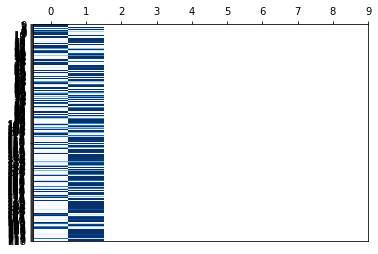

In [16]:
# And a heat map...
heat_map = [ prediction['probabilities'] for prediction in predictions]

show_heat_map(heat_map) 

In [17]:
# Testing surprised dataset
dataset_test = pickle.load(open(os.path.join('Datasets', 'surprised.pkl'), 'rb'))

print("surprised test data loaded")

surprised test data loaded


In [18]:
predictions = get_predictions_for_dataset(dataset_test)

print()

happy_counter = 0
angry_counter = 0

for i, prediction in enumerate(predictions):
    probs = ','.join([ "%6.2f%%" % (p*100,) for p in prediction['probabilities']] )
    if prediction['classes'] == 0:
        happy_counter += 1
    elif prediction['classes'] == 1:
        angry_counter += 1
    print( "%d  p=[%s]" % (prediction['classes'],  probs,))

stamps.shape: (210, 224, 224)
labels.shape: (210,)
batch_input_fn sizing :  (210, 224, 224, 1)
INFO:tensorflow:Restoring parameters from cnn_model/emotions_en_de/model.ckpt-5700

0  p=[100.00%,  0.00%]
0  p=[ 99.99%,  0.01%]
0  p=[ 98.09%,  1.91%]
0  p=[ 86.23%, 13.77%]
0  p=[ 99.99%,  0.01%]
0  p=[ 99.49%,  0.51%]
0  p=[100.00%,  0.00%]
1  p=[  0.44%, 99.56%]
0  p=[ 99.29%,  0.71%]
1  p=[  0.00%,100.00%]
0  p=[100.00%,  0.00%]
0  p=[ 99.97%,  0.03%]
0  p=[ 81.01%, 18.99%]
0  p=[ 98.76%,  1.24%]
1  p=[  0.03%, 99.97%]
1  p=[ 20.42%, 79.58%]
0  p=[ 99.99%,  0.01%]
1  p=[  0.81%, 99.19%]
0  p=[ 52.62%, 47.38%]
1  p=[ 33.93%, 66.07%]
0  p=[100.00%,  0.00%]
1  p=[  0.00%,100.00%]
0  p=[ 99.65%,  0.35%]
1  p=[ 35.58%, 64.42%]
0  p=[ 96.10%,  3.90%]
0  p=[100.00%,  0.00%]
0  p=[ 99.11%,  0.89%]
0  p=[100.00%,  0.00%]
0  p=[ 99.96%,  0.04%]
1  p=[  0.52%, 99.48%]
0  p=[ 99.71%,  0.29%]
1  p=[  0.33%, 99.67%]
0  p=[ 99.85%,  0.15%]
0  p=[100.00%,  0.00%]
1  p=[ 10.04%, 89.96%]
1  p=[  0.01%, 9

In [19]:
print("voice predicted happy: ", happy_counter)
print("voice predicted angry: ", angry_counter)

voice predicted happy:  138
voice predicted angry:  72


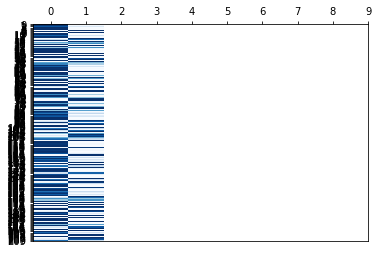

In [20]:
# And a heat map...
heat_map = [ prediction['probabilities'] for prediction in predictions]

show_heat_map(heat_map) 